### Classifiers and Regressors

#### Classifiers and Regressors help cells

In [1]:
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
import numpy as np

In [2]:
# datasets: list of datasets or single dataset, depending on if multiple_datasets is set to True
# make_categorical_data: transform numeric -1, 0, 1 data to categorical data, for each dimension 2 new ones, 
#       one with either SIMP/NOT_SIMP and one for ABSTAIN
# use1249LFs: use the fully unpruned dataset
def load_data(datasets, make_categorical_data, use1249LFs=False, multiple_datasets=False):
    KAT = ''
    if make_categorical_data:
        KAT = '_KAT'

    data_merged = []
    labels = []

    if not multiple_datasets:
        datasets = [datasets]

    for d_s in datasets:    
        if use1249LFs:
            simp_path = f"/workspace/datasets/__all_LFs/{d_s}-1249_simp_labels.pkl"        
            src_path = f"/workspace/datasets/__all_LFs/{d_s}-1249_src_labels.pkl"  
        else:
            simp_path = f"/workspace/datasets/ds_labels/{d_s}_simp_labels.pkl"        
            src_path = f"/workspace/datasets/ds_labels/{d_s}_src_labels.pkl"  

        simp_labels = pickle.load(open(simp_path, "rb"))
        src_labels = pickle.load(open(src_path, "rb")) 

        for entry in simp_labels:
            if make_categorical_data:
                new_ent = []
                for e in entry:
                    if e == -1:
                        new_ent.append(0)
                        new_ent.append(0)

                    if e == 0:
                        new_ent.append(1)
                        new_ent.append(0)

                    if e == 1:
                        new_ent.append(0)
                        new_ent.append(1)
                    
                data_merged.append(new_ent)
            else:
                data_merged.append(entry.tolist())

        for entry in src_labels:
            if make_categorical_data:
                new_ent = []
                for e in entry:
                    if e == -1:
                        new_ent.append(0)
                        new_ent.append(0)

                    if e == 0:
                        new_ent.append(1)
                        new_ent.append(0)

                    if e == 1:
                        new_ent.append(0)
                        new_ent.append(1)

                data_merged.append(new_ent)
            else:
                data_merged.append(entry.tolist())

        curr_lab = [0] * len(simp_labels) + [1] * len(simp_labels)
        labels = labels + curr_lab

    X, y = shuffle(data_merged, labels, random_state=42)
    return X, y, KAT

In [3]:
clf_gb = GradientBoostingClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)

clfs = {'gb': clf_gb, 'rf': clf_rf}

reg_gb = GradientBoostingRegressor(random_state=42)
reg_rf = RandomForestRegressor(random_state=42)
reg_mlp = MLPRegressor(random_state=42)

regs = {'reg_gb': reg_gb, 'reg_rf': reg_rf, 'reg_mlp': reg_mlp}

In [4]:
def run_classifiers(run, X, y, run_type, n):
    if run:
        output = ''
        kfold = KFold(n_splits=n, shuffle=True, random_state=42)
        for clf in clfs:
            cv_scores = cross_val_score(clfs[clf], X, y, cv=kfold)
            output += clf + ' (' + run_type + ') : '
            output += str(sum(cv_scores)/len(cv_scores)) + '\n'
            output += str(cv_scores) + '\n___\n'
        return output, sum(cv_scores)/len(cv_scores)
    return '', 0

def run_single_classifier(X_train, y_train, clf_name, n, X_test=None, y_test=None):
    score = -1
    curr_clf = clfs[clf_name].fit(X_train, y_train)

    if X_test and y_test:
        score = curr_clf.score(X_test, y_test)
    else:
        X_test = X_train
        y_test = y_train

    # find dimensions of most important LFs
    perm_importance = permutation_importance(curr_clf, X_test, y_test).importances_mean
    if n < 0:
        return perm_importance, score
    top_LFs = np.argsort(perm_importance)[::-1][:n]

    return top_LFs, score

def run_regressors(run, X, y, n):
    if run:
        output = ''
        kfold = KFold(n_splits=n, shuffle=True, random_state=42)
        for reg in regs:
            cv_scores = cross_val_score(regs[reg], X, y, cv=kfold)
            output += reg + ': '
            output += str(sum(cv_scores)/len(cv_scores)) + '\n'
            output += str(cv_scores) + '\n___\n'
        return output, sum(cv_scores)/len(cv_scores)
    return '', 0

#### Classifiers and Regressors run

In [5]:
def run():
    datasets = 'Wiki-Manual' #'britannica', 'ASSET', 'MTurkSF', 'Wiki-Manual','eval'

    n = 10

    X, y, KAT = load_data(datasets, make_categorical_data=False, use1249LFs=True)
    print(run_classifiers(True, X, y, 'vanilla' + KAT, n)[0])
    print(run_regressors(False, X, y, n)[0])

run()

gb (vanilla) : 0.4573053486797563
[0.44075829 0.41232227 0.46919431 0.46445498 0.45971564 0.47393365
 0.43127962 0.507109   0.50952381 0.4047619 ]
___
rf (vanilla) : 0.3026404874746107
[0.30331754 0.32227488 0.33649289 0.29383886 0.30331754 0.27488152
 0.28436019 0.33649289 0.30952381 0.26190476]
___




### Feature Selection

#### Feature Selection help cells

In [6]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
from tqdm import tqdm

In [7]:
# naive_categorical_tuples: if using the naive_feature_selection_count and make_categorical_data and 1 dim of the 2 belonging together is chosen,
#       should the two dimensions both be considered together in the resulting dimensions
def run_naive_feature_selection(X, y, k, naive_categorical_tuples):    
    dims_to_include = []
    
    # only include dimensions where values are the most different 
    for lf_dim in range(len(X[0])):
        sum_i_src = 0
        sum_i_simp = 0
        for d_p in range(len(X)):
            if y[d_p] == 0:
                sum_i_simp += X[d_p][lf_dim]
            else:
                sum_i_src += X[d_p][lf_dim]

        dist = abs(sum_i_simp - sum_i_src)

        if len(dims_to_include) < k:
            dims_to_include.append((lf_dim, dist))
        else:
            replace_cand_dist = -1
            replace_cand_dim = -1
            # find dim with lowest dist
            for inc_dim in range(len(dims_to_include)):
                if dims_to_include[inc_dim][1] < dist and (replace_cand_dist == -1 or replace_cand_dist > dims_to_include[inc_dim][1]):
                    replace_cand_dim = inc_dim
                    replace_cand_dist = dims_to_include[inc_dim][1]
                        
            # replace it
            if replace_cand_dim > -1:
                dims_to_include[replace_cand_dim] = (lf_dim, dist)

    X_naive = []
    for d_p in range(len(X)):
        new_dp = []
        all_bases = []
        for inc_dims in dims_to_include:
            if naive_categorical_tuples:
                # check if dim has already been included
                base = int(inc_dims[0] / 2)
                if base not in all_bases:
                    all_bases.append(base)
                    base_dim = 2 * base

                    new_dp.append(X[d_p][base_dim])
                    new_dp.append(X[d_p][base_dim + 1])
            else:
                new_dp.append(X[d_p][inc_dims[0]])
        X_naive.append(new_dp)
    return X_naive

def run_chi2(X, y, k):
    X_chi2 = SelectKBest(chi2, k=k).fit_transform(X, y)
    return X_chi2

def run_mean_importance(X, y, k, n, clf_name):
    kfold = KFold(n_splits=n, shuffle=True, random_state=42)

    feature_importances = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = np.take(X, train_index, axis=0), np.take(X, test_index, axis=0)
        y_train, y_test = np.take(y, train_index), np.take(y, test_index)

        curr_clf = clfs[clf_name]
        curr_clf.fit(X_train, y_train)

        perm_importance = permutation_importance(curr_clf, X_test, y_test)
        feature_importances.append(perm_importance.importances_mean)

    mean_importance = np.mean(feature_importances, axis=0)
    sorted_indices = np.argsort(mean_importance)[::-1]
    top_k_indices = sorted_indices[:k]

    X_mean_importance = []

    for dp in X:
        new_dp = []
        for dim in top_k_indices:
            new_dp.append(dp[dim])
        X_mean_importance.append(new_dp)
    return X_mean_importance

def run_random(X, y, k):
    dims_to_include = shuffle(range(0, len(X[0]) - 1), random_state=42)[:k]

    X_random = []

    for d_p in range(len(X)):
        new_dp = []
        for inc_dims in dims_to_include:
            new_dp.append(X[d_p][inc_dims])
        X_random.append(new_dp)
    return X_random

#### Feature Selection run

In [8]:
def run_feature_selection(X, y, n, KAT, clf_name, lower=10, upper=-1):
    if upper == -1:
        upper = len(X[0])-1
    all_res = []

    for i in tqdm(range(lower, upper, 10)):
        num_cat = i
        
        if len(X[0]) < num_cat:
            print('Error: Number of categories smaller than dimensions of input data!')
            exit()

        X_naive = run_naive_feature_selection(X, y, num_cat, False)
        X_chi2 = run_chi2(X, y, num_cat)
        X_mean_importance = run_mean_importance(X, y, num_cat, n, clf_name)
        X_random = run_random(X, y, num_cat)

        naive_score = run_classifiers(True, X_naive, y, 'naive' + KAT + '_' + str(num_cat))[1]
        chi_score = run_classifiers(True, X_chi2, y, 'chi2' + KAT + '_' + str(num_cat))[1]
        meanImp_score = run_classifiers(True, X_mean_importance, y, 'mean importance' + KAT + '_' + str(num_cat))[1]
        rand_score = run_classifiers(True, X_random, y, 'random' + KAT + '_' + str(num_cat))[1]

        all_res.append([naive_score, chi_score, meanImp_score, rand_score])
    return all_res, lower, upper

#### Feature Selection Visualisation

In [9]:
!pip install seaborn

In [10]:
import pickle as pkl
import seaborn as sns
from scipy import stats

In [11]:
def save_visualisation(datasets, newly_generated = False):
    if newly_generated:
        with open('/workspace/datasets/performance_of_features/' + datasets[0] + '_performance_of_feature_selection.pkl', 'wb') as f:
            pkl.dump(all_res, f)
    else:
        all_res = pd.read_pickle('/workspace/datasets/performance_of_features/' + datasets[0] + '_performance_of_feature_selection.pkl')

def run_visualisation(all_res, datasets, X, lower=10, upper=-1):
    if upper == -1:
        upper = len(X[0])-1
    df = pd.DataFrame(all_res, index=range(lower, upper, 10), columns=['naive approach', 'chi2', 'mean importance', 'random'])
    sns.lineplot(data=df).set(title=datasets[0], xlabel='Number of Dimensions', ylabel='Mean Accuracy')

### Find most important LF per Dataset

In [12]:
clf_name = 'gb'

In [13]:
datasets = [] #['MTurkSF']#, 'simpa']
top_dims_single = []

for ds in datasets:
    X, y, KAT = load_data(ds, make_categorical_data=False, use1249LFs=True)
    topLFs, score = run_single_classifier(X, y, clf_name, -1)
    top_dims_single.append(topLFs)

#### Rank correlation

In [112]:
def calc_dim_imp(datasets, clf_name):
    top_LFs_of_all_ds = {}

    for a in datasets:
        X, y, KAT = load_data(a, make_categorical_data=False, use1249LFs=True)
        topLFs, score = run_single_classifier(X, y, clf_name, -1)
        top_LFs_of_all_ds[a] = topLFs

    return top_LFs_of_all_ds

def prune_dims(datasets, top_LFs_of_all_ds, k):
    only_top_LFs_of_all_ds = {}

    for a in datasets:
        sorted = np.argsort(top_LFs_of_all_ds[a])[::-1]
        top_k_indices = sorted[:k]
        pruned_values = []
        for dim in range(len(top_LFs_of_all_ds[a])):
            if dim in top_k_indices:
                pruned_values.append(top_LFs_of_all_ds[a][dim])
            else:
                pruned_values.append(0)
        
        only_top_LFs_of_all_ds[a] = pruned_values
    
    return only_top_LFs_of_all_ds

def calc_spearman(datasets, top_LFs_of_all_ds):
    spears = []
    for a in range(len(datasets)):
        for b in range(a + 1, len(datasets)):
            res = stats.spearmanr(top_LFs_of_all_ds[datasets[a]], top_LFs_of_all_ds[datasets[b]])
            #print(datasets[a] + ' - ' + datasets[b] + ': ' +  str(res.statistic))
            spears.append(res.statistic)
    return sum(spears)/len(spears)

def calc_overlap(datasets, top_LFs_of_all_ds, num_dims):
    if len(datasets) > 1:
        overlaps = []
        for a in range(len(datasets)):
            for b in range(a + 1, len(datasets)):
                # iterate through all dimensions to calculate overlap
                identical_dims = 0
                for i in range(len(top_LFs_of_all_ds[datasets[a]])):

                    if top_LFs_of_all_ds[datasets[a]][i] > 0 and top_LFs_of_all_ds[datasets[b]][i] > 0:
                        identical_dims += 1

                overlaps.append(identical_dims/num_dims)
        return sum(overlaps)/len(overlaps)
    else:
        return 0

def calc_thresless_overlap(datasets, top_LFs_of_all_ds, num_dims, name_to_thresless, dims_to_names):
    overlaps = []
    dataset_LFs = {}
    for a in range(len(datasets)):
        for i in range(len(top_LFs_of_all_ds[datasets[a]])):
            if top_LFs_of_all_ds[datasets[a]][i] > 0:
                if a not in dataset_LFs:
                    dataset_LFs[a] = []
                for actual_lf in dims_to_names[i]:
                    dataset_LFs[a].append(name_to_thresless[actual_lf])

    for a in range(len(datasets)):            
        for b in range(a + 1, len(datasets)):
            #print(num_dims)
            #print(dataset_LFs[a])
            #print(dataset_LFs[b])
            intersection_a = [x for x in dataset_LFs[a] if x in dataset_LFs[b]]
            intersection_b = [x for x in dataset_LFs[b] if x in dataset_LFs[a]]

            #print(len(intersection_a))
            #print(len(intersection_b))
            #print((len(intersection_a) + len(intersection_b))/(len(dataset_LFs[a]) + len(dataset_LFs[b])))
            #print('_____')
            overlaps.append(min(len(intersection_a), len(intersection_b))/len(dataset_LFs[a]))
    return sum(overlaps)/len(overlaps)



def draw_data(df, t, y):
    sns.lineplot(data=df).set(title=t, xlabel='Number of Dimensions', ylabel=y)

In [15]:
datasets = ['BenchLS', 'britannica', 'HutSSF', 'MTurkSF', 'NNSeval', 'SemEval_2007', 'simpa', 'Wiki-Manual']

top_LFs_of_all_ds_GB = calc_dim_imp(datasets, clf_name)

In [16]:
#top_LFs_of_all_ds_RF = top_LFs_of_all_ds

In [17]:
calc_spearman(datasets, top_LFs_of_all_ds_GB)

0.06501036610455024

In [18]:
data = {}
for i in range(1249):
    only_top_LFs_of_all_ds = prune_dims(datasets, top_LFs_of_all_ds_GB, i)
    val = calc_spearman(datasets, only_top_LFs_of_all_ds)
    data[i] = val

/usr/local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


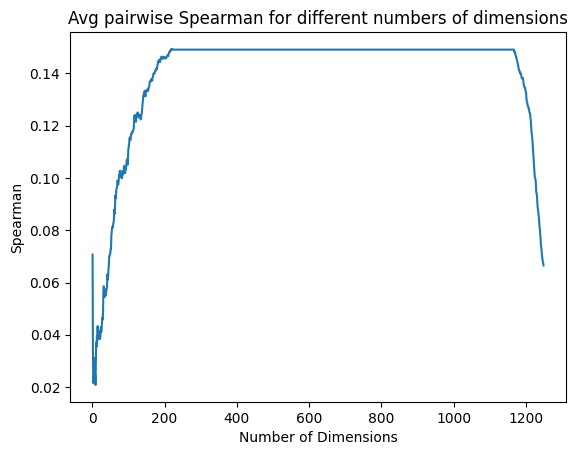

In [19]:
draw_data(data, 'Avg pairwise Spearman for different numbers of dimensions', 'Spearman')

In [20]:
datasets = [] #[['MTurkSF', 'simpa'], ['simpa', 'MTurkSF']]
top_dims_merge = []
scores = []

for ds in datasets:
    X, y, KAT = load_data(ds[0], make_categorical_data=False, use1249LFs=True)
    X2, y2, KAT = load_data(ds[1], make_categorical_data=False, use1249LFs=True)
    topLFs, score = run_single_classifier(X, y, clf_name, -1, X2, y2)
    top_dims_merge.append(topLFs)
    scores.append(score)

In [21]:
top_dims_merge

[]

In [22]:
scores

[]

In [32]:
# todo: Berechne Overlap
data_overlap = {}
for i in range(1, 1249):
    only_top_LFs_of_all_ds = prune_dims(datasets, top_LFs_of_all_ds_GB, i)
    val = calc_overlap(datasets, only_top_LFs_of_all_ds, i)
    data_overlap[i] = val

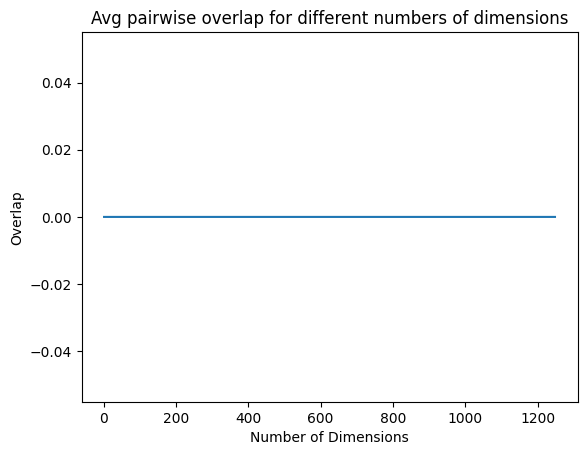

In [33]:
draw_data(data_overlap, 'Avg pairwise overlap for different numbers of dimensions', 'Overlap')

### Mapping of LFs to thresless and categories

In [34]:
from matcher import get_mapping_of_LF_and_dims

/usr/local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


resources get initialised


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
dims_to_names, names_to_dims, name_to_thresless, name_to_category = get_mapping_of_LF_and_dims()
datasets = ['BenchLS', 'britannica', 'HutSSF', 'MTurkSF', 'NNSeval', 'SemEval_2007', 'simpa', 'Wiki-Manual']

In [108]:
# most important dims per dataset
only_top_LFs_of_all_ds = prune_dims(datasets, top_LFs_of_all_ds_GB, 10)
for a in datasets:
    LFs = set()
    for i in range(1249):
        if only_top_LFs_of_all_ds[a][i] > 0:
            LFs.add(dims_to_names[i][0])
    print(a + ' ' + str(len(LFs)))
    print(LFs)

BenchLS 10
{'lf_infrequent_words_per_sentence=4_leopard_NOT_SIMPLE', 'low_prop_long_words_syllables_long=3_prop=0.075_label=0', 'high_fkre_threshold=50_1', 'lf_infrequent_words_cnt=3_octopus_NOT_SIMPLE', 'lf_med_imageability=3.65_SIMPLE', 'lf_median_concreteness=2.125_NOT_SIMPLE', 'lf_infrequent_words_per_sentence=3_octopus_NOT_SIMPLE', 'lf_max_age_of_acquisition=9_SIMPLE', 'low_prop_long_words_letters_long=7_prop=0.2_label=0', 'percentage_appositions=0.01_0'}
britannica 10
{'depth_of_syntactic_tree_label=0_thresh=3', 'entity_token_ratio_sentence_label=0_thresh=0.065', 'lf_max_age_of_acquisition=11_SIMPLE', 'avg_num_punctuation_text_label=0_thresh=1.95', 'avg_num_punctuation_text_label=0_thresh=1.5', 'lf_infrequent_words_per_sentence=2_bunny_NOT_SIMPLE', 'high_fkre_threshold=60_0', 'low_modifier_ratio_thres=0.01_label=0', 'lf_max_age_of_acquisition=9_SIMPLE', 'low_prop_long_words_letters_long=9_prop=0.15_label=0'}
HutSSF 10
{'low_prop_long_words_syllables_long=2_prop=0.1_label=0', 'avg

In [109]:
# most important dims per dataset
dataset_LFs = {}
only_top_LFs_of_all_ds = prune_dims(datasets, top_LFs_of_all_ds_GB, 10)
for a in datasets:
    LFs = set()
    for i in range(1249):
        if only_top_LFs_of_all_ds[a][i] > 0:
            LFs.add(name_to_thresless[dims_to_names[i][0]])
            
    print(a + ' ' + str(len(LFs)))
    print(LFs)
    dataset_LFs[a] = LFs

BenchLS 9
{'infrequent_words_lfs_complex', 'lfs_proportions_of_long_words_letters_simple', 'max_aoa_lfs_simple', 'lfs_high_fkre_complex', 'infrequent_words_per_sentence_lfs_complex', 'median_concreteness_lfs_complex', 'med_image_lfs_simple', 'lfs_percentage_appositions_simple', 'lfs_proportions_of_long_words_syllables_simple'}
britannica 8
{'avg_depth_of_syntactic_tree_lfs', 'lfs_low_modifier_ratio_thres_simple', 'max_aoa_lfs_simple', 'lfs_high_fkre_simple', 'entity_token_ratio_sentence_lfs', 'infrequent_words_per_sentence_lfs_complex', 'avg_num_punctuation_text_lfs', 'lfs_proportions_of_long_words_syllables_simple'}
HutSSF 8
{'lfs_proportions_of_long_words_letters_simple', 'ratio_academic_word_list_lfs', 'lfs_few_noun_phrases', 'avg_num_words_before_main_verb_lfs', 'entity_token_ratio_sentence_lfs', 'median_concreteness_lfs_complex', 'lfs_proportions_of_long_words_syllables_simple', 'lfs_low_sents_num'}
MTurkSF 6
{'infrequent_words_lfs_complex', 'lfs_low_modifier_ratio_thres_simple', 

In [113]:
# todo: Berechne Overlap
data_overlap = {}
for i in range(1, 1250):
    only_top_LFs_of_all_ds = prune_dims(datasets, top_LFs_of_all_ds_GB, i)
    val = calc_thresless_overlap(datasets, only_top_LFs_of_all_ds, i, name_to_thresless, dims_to_names)
    data_overlap[i] = val

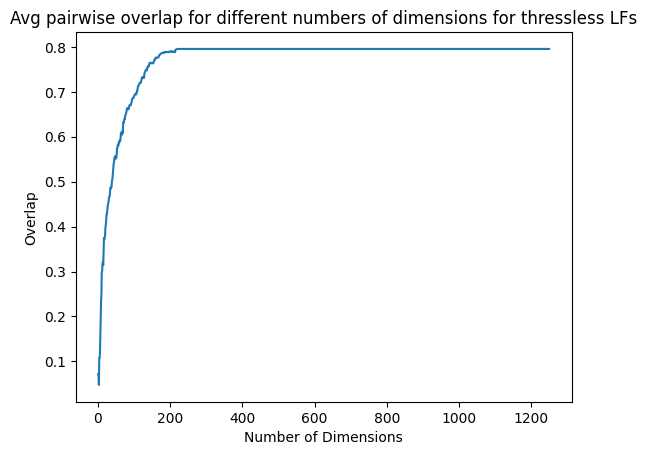

: 

In [114]:
draw_data(data_overlap, 'Avg pairwise overlap for different numbers of dimensions for thressless LFs', 'Overlap')